# **Traffic Sign Recognition using CNN**

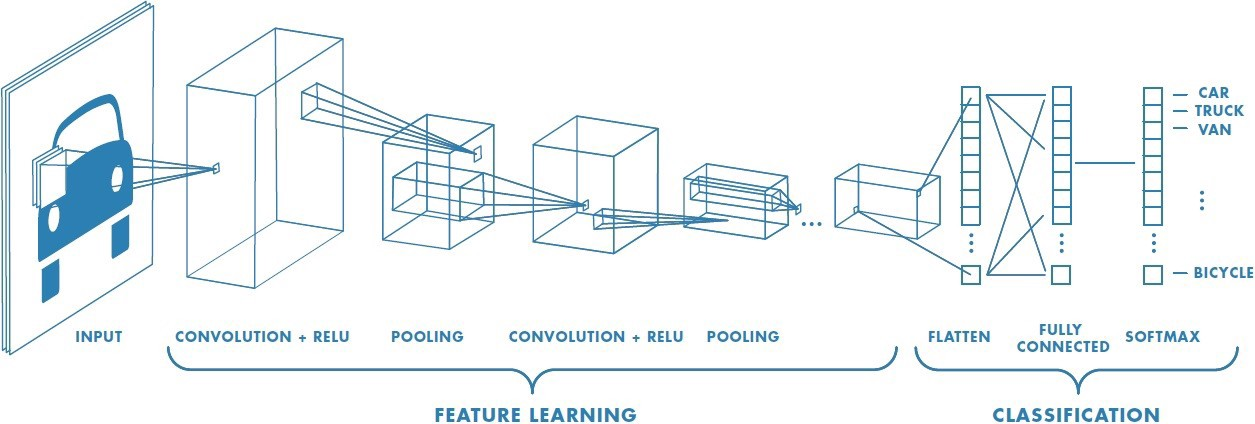

By: [Balamurugan P](https://www.linkedin.com/in/bala-murugan-62073b212/)

> **TASK** : To classify traffic signs into 43 distinct classes.

# **Data:**

> **Raw Data:** https://www.kaggle.com/flo2607/traffic-signs-classification<br><br>
> **Train-Val Split:** https://www.kaggle.com/balamurugan1603/traffic-signs-train-val-split

# **Dependencies:**

In [1]:
# Import dependencies
import os
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import random
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.models import save_model
from keras.callbacks import EarlyStopping

# **Doing a quick EDA:**

*EDA was done on data before splitting them into training and validation sets.*

In [2]:
# Path to raw data
data_path = "../input/traffic-signs-classification/myData"

# Listing sub directories
sub_directories = os.listdir(data_path)

# Loading labels
labels = pd.read_csv("../input/traffic-signs-classification/labels.csv")

In [3]:
# Finding number of classes in the data
print("Number of Classes: ",len(sub_directories))

Number of Classes:  43


In [4]:
# Finding number of images under each class
no_of_images = []
for directory in sub_directories:
    no_of_images.append(len(os.listdir(os.path.join(data_path, directory))))

labels["n_samples"] = no_of_images
labels.sort_values(["n_samples"], inplace=True)

# Displaying DataFrame containing class name, directory name and number of samples 
display(labels)

,ClassId,Name,n_samples
2,2,Speed limit (50km/h),390
39,39,Keep left,390
12,12,Priority road,450
16,16,Vechiles over 3.5 metric tons prohibited,450
14,14,Stop,450
11,11,Right-of-way at the next intersection,450
20,20,Dangerous curve to the right,451
41,41,End of no passing,510
42,42,End of no passing by vechiles over 3.5 metric ...,510
13,13,Yield,570


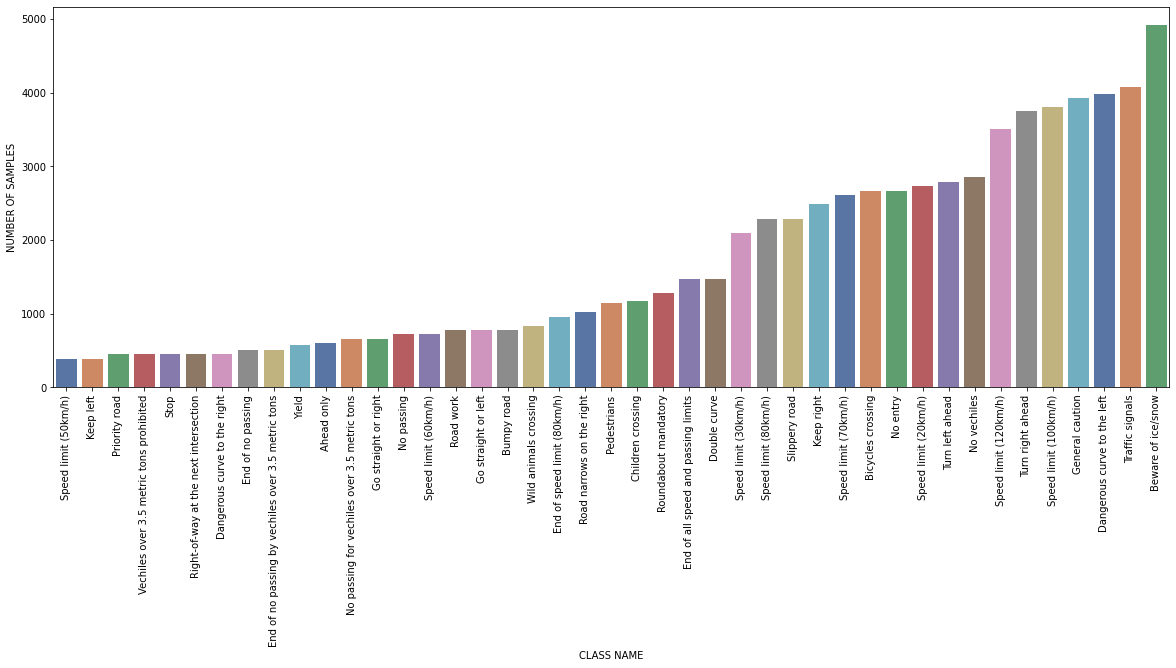

In [5]:
# Visualising number of samples under each class
f, ax = plt.subplots(figsize=(20, 7))
sns.barplot(x=labels["Name"], y=labels["n_samples"], palette="deep")
plt.xlabel("CLASS NAME")
plt.ylabel("NUMBER OF SAMPLES")
plt.xticks(rotation=90)
plt.show()

*From the visulization, It is clear that our dataset has class imbalance.*

In [6]:
# checking resolution of the images
res = cv2.imread(os.path.join(data_path, sub_directories[0], os.listdir(os.path.join(data_path, sub_directories[0]))[0])).shape
print("Height: ", res[0])
print("Width: ", res[1])
print("Number of Channels: ", res[2])
print("Resolution: {}x{}".format(res[0], res[1]))

Height:  32
Width:  32
Number of Channels:  3
Resolution: 32x32


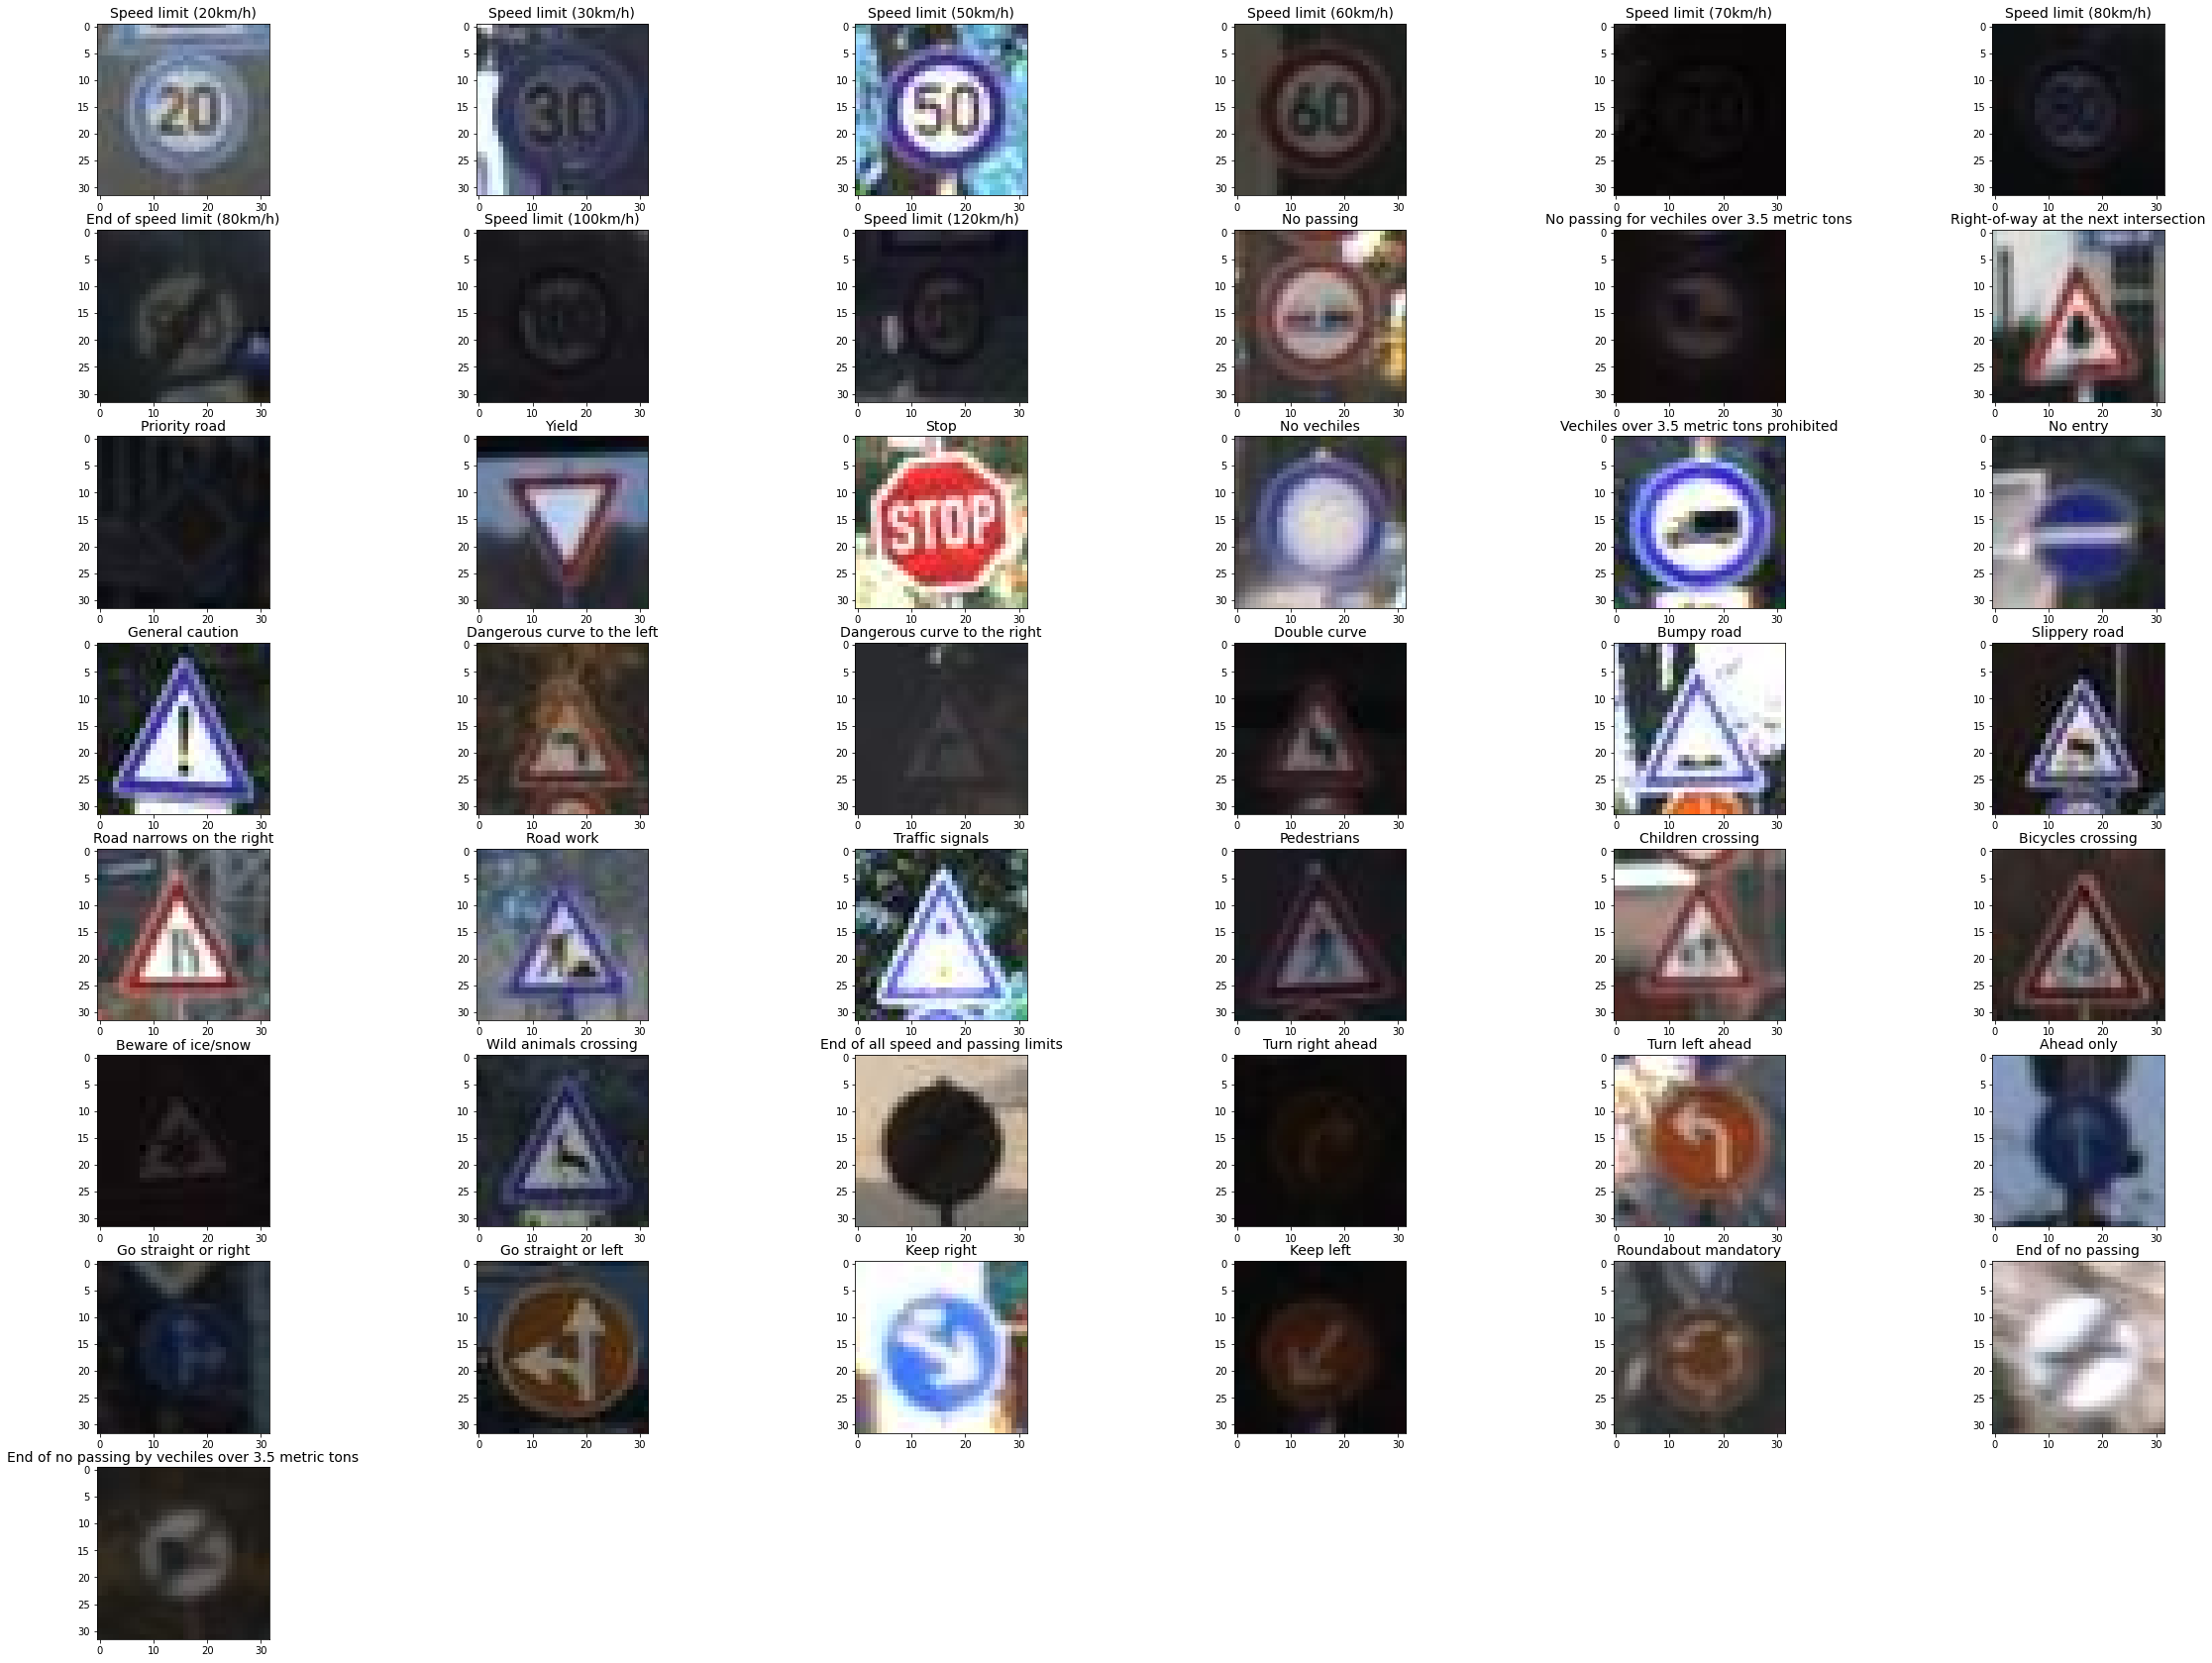

In [7]:
# displaying some images randomly from each class
fig = plt.figure(figsize=(40, 30))
rows = 8
cols = 6
for directory in sub_directories:
    current_dir_files = os.listdir(os.path.join(data_path, directory))
    img = cv2.imread(os.path.join(data_path, directory, current_dir_files[random.randint(len(current_dir_files))]))
    fig.add_subplot(rows, cols, int(directory)+1)
    plt.imshow(img)
    plt.title(labels["Name"][int(directory)], fontsize=14)

# **Data Augmentation:**

*Before creating ImageDataGenerator object, We must prepare data which is compatible with ImageDataGenerator. So, I have created a different dataset where I have split the data into training and validation sets which is the one I used here.*

In [8]:
# Data Generators will augment the data and feed it to our models

train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             zoom_range=0.2,
                             fill_mode="nearest").flow_from_directory("../input/traffic-signs-train-val-split/traffic signs split/train",
                                                                      target_size=(32, 32),
                                                                      batch_size=32,
                                                                      class_mode="categorical")

val_datagen = ImageDataGenerator(rescale=1./255).flow_from_directory("../input/traffic-signs-train-val-split/traffic signs split/val",
                                                                     target_size=(32, 32),
                                                                     batch_size=32,
                                                                     class_mode="categorical")

Found 58510 images belonging to 43 classes.
Found 14629 images belonging to 43 classes.


# **Defining and Compiling the model:**

**Read About Convolutional Networks:**
<br>https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

In [9]:
# Function to create model
def create_model(activation="relu"):
    
    """ Creates and returns image classification model.
    
    Args:
        activation (str): Activation function to be used in first 
                          few layers.
    Returns:
        model (tensorflow model): Compiled image classification model.
    """
    
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation=activation, input_shape=(32, 32, 3)))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(32, (3,3), activation=activation))
    model.add(MaxPool2D(2, 2))
    model.add(Conv2D(64, (3,3), activation=activation))
    model.add(Flatten())
    model.add(Dense(512, activation=activation))
    model.add(Dense(256, activation="tanh"))
    model.add(Dense(128, activation="tanh"))
    model.add(Dense(43, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [10]:
# Creating model
TrafficSignRecogniser = create_model()

# Displays model architecture
TrafficSignRecogniser.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               5

# **Training the model:**

In [11]:
# Trains the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=100, patience=5)
history = TrafficSignRecogniser.fit_generator(train_datagen, validation_data=val_datagen, epochs=20, verbose=100, callbacks=[es])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 00014: early stopping


# **Plotting the Error:**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  import sys


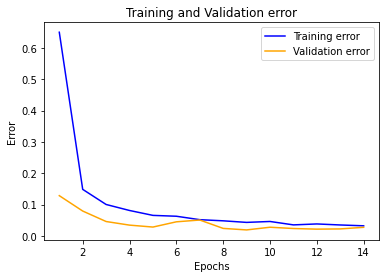

In [12]:
# Plots training loss and validation loss from training history
history_dict = history.history
train_acc = history_dict['loss']
val_acc = history_dict['val_loss']
epochs = range(1, len(history_dict['loss'])+1)
plt.plot(epochs, train_acc,'b', label='Training error')
plt.plot(epochs, val_acc,'b', color="orange", label='Validation error')
plt.title('Training and Validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

# **Saving the model:**

In [13]:
# Saves the model
save_model(TrafficSignRecogniser, "TrafficSignRecogniser")